# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def kmeans_clustering_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'fuel': [y_train[i][0] for i in temp],
                    'machine': [y_train[i][1] for i in temp],
                    'others': [y_train[i][2] for i in temp],
                    'part': [y_train[i][3] for i in temp],
                    'price': [y_train[i][4] for i in temp],
                    'service': [y_train[i][5] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [21]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'casa-kmeans-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6716, Accuracy: 0.6763, F1 Micro: 0.7845, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.623, Accuracy: 0.724, F1 Micro: 0.8277, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5676, Accuracy: 0.7478, F1 Micro: 0.8485, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5258, Accuracy: 0.776, F1 Micro: 0.8712, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4874, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.453, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.4214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4196, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.3868, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.3569, Accuracy: 0.7917, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.7778, F1 Micro: 0.7778, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4977, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3777, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2928, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2176, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1723, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6291, Accuracy: 0.7202, F1 Micro: 0.8262, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5393, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 3/10, Train Loss: 0.5001, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4817, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4644, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4343, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4518, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3749, Accuracy: 0.7991, F1 Micro: 0.8869, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3642, Accuracy: 0.8103, F1 Micro: 0.8925, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3489, Accuracy: 0.8296, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6609, Accuracy: 0.7213, F1 Micro: 0.7213, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6008, Accuracy: 0.7213, F1 Micro: 0.7213, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6231, Accuracy: 0.7213, F1 Micro: 0.7213, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6088, Accuracy: 0.7213, F1 Micro: 0.7213, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5486, Accuracy: 0.7213, F1 Micro: 0.7213, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5002, Accuracy: 0.7213, F1 Micro: 0.7213, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.5201, Accuracy: 0.7377, F1 Micro: 0.7377, F1 Macro: 0.4786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4664, Accuracy: 0.7705, F1 Micro: 0.7705, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.471

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.604, Accuracy: 0.7932, F1 Micro: 0.8836, F1 Macro: 0.8818
Epoch 2/10, Train Loss: 0.4883, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.496, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4556, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4105, Accuracy: 0.8229, F1 Micro: 0.899, F1 Macro: 0.8978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.378, Accuracy: 0.8624, F1 Micro: 0.9189, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3211, Accuracy: 0.9033, F1 Micro: 0.9411, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2769, Accuracy: 0.9152, F1 Micro: 0.9476, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.234, Accuracy: 0.9211, F1 Micro: 0.9512, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5744, Accuracy: 0.6853, F1 Micro: 0.6853, F1 Macro: 0.4066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5635, Accuracy: 0.6853, F1 Micro: 0.6853, F1 Macro: 0.4066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4548, Accuracy: 0.7026, F1 Micro: 0.7026, F1 Macro: 0.557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.34, Accuracy: 0.819, F1 Micro: 0.819, F1 Macro: 0.7945
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2492, Accuracy: 0.819, F1 Micro: 0.819, F1 Macro: 0.7885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1655, Accuracy: 0.8621, F1 Micro: 0.8621, F1 Macro: 0.8483
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8491, F1 Micro: 0.8491, F1 Macro: 0.8231
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.8621, F1 Micro: 0.8621, F1 Macro: 0.8401
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.875, F1 Micro: 0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4705, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4711, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4263, Accuracy: 0.8185, F1 Micro: 0.8969, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3684, Accuracy: 0.8661, F1 Micro: 0.9207, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.32, Accuracy: 0.9152, F1 Micro: 0.9478, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2519, Accuracy: 0.9219, F1 Micro: 0.9519, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1945, Accuracy: 0.9249, F1 Micro: 0.9532, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6334, Accuracy: 0.6862, F1 Micro: 0.6862, F1 Macro: 0.4069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5528, Accuracy: 0.6862, F1 Micro: 0.6862, F1 Macro: 0.4533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.435, Accuracy: 0.8201, F1 Micro: 0.8201, F1 Macro: 0.8088
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2585, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.911
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9205, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5695, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.483, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4578, Accuracy: 0.8162, F1 Micro: 0.8957, F1 Macro: 0.8945
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3744, Accuracy: 0.8638, F1 Micro: 0.9196, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3246, Accuracy: 0.9062, F1 Micro: 0.9423, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2578, Accuracy: 0.9293, F1 Micro: 0.9558, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2078, Accuracy: 0.9405, F1 Micro: 0.9628, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1734, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6129, Accuracy: 0.6944, F1 Micro: 0.6944, F1 Macro: 0.4098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5159, Accuracy: 0.7421, F1 Micro: 0.7421, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.322, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9345
Epoch 5/10, Train Loss: 0.0956, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9102
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9563, F1 Micro: 0.9563, F1 Macro: 0.9488
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9407
Epoch 10/10, Train Loss: 0.0501, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4762, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4171, Accuracy: 0.8296, F1 Micro: 0.9024, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3513, Accuracy: 0.9092, F1 Micro: 0.9444, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2753, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2085, Accuracy: 0.9442, F1 Micro: 0.9652, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1631, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.1314, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1135, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5347, Accuracy: 0.6798, F1 Micro: 0.6798, F1 Macro: 0.4047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4607, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9287
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.938
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9245
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9151
Epoch 10/10, Train Loss: 0.0281, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4696, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4361, Accuracy: 0.8504, F1 Micro: 0.912, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3489, Accuracy: 0.9182, F1 Micro: 0.9486, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2617, Accuracy: 0.942, F1 Micro: 0.9637, F1 Macro: 0.9623
Epoch 6/10, Train Loss: 0.2052, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1683, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1356, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.111, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5475, Accuracy: 0.7114, F1 Micro: 0.7114, F1 Macro: 0.5816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3699, Accuracy: 0.878, F1 Micro: 0.878, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.936
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9371
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9328
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.9545
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.912
Epoch 10/10, Train Loss: 0.0174, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5425, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4732, Accuracy: 0.8177, F1 Micro: 0.8965, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3931, Accuracy: 0.8981, F1 Micro: 0.938, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.306, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2187, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1796, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0852, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5888, Accuracy: 0.6772, F1 Micro: 0.6772, F1 Macro: 0.4038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3658, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9331
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9456
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9385
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9301
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.92
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5362, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4804, Accuracy: 0.8192, F1 Micro: 0.8973, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3803, Accuracy: 0.9018, F1 Micro: 0.9384, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2803, Accuracy: 0.9368, F1 Micro: 0.9605, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2155, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1264, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5802, Accuracy: 0.6858, F1 Micro: 0.6858, F1 Macro: 0.4292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3666, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9617, F1 Micro: 0.9617, F1 Macro: 0.9564
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9438
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9261
Epoch 10/10, Train Loss: 0.057, Accuracy: 0.9464, F1 Micro: 0.9464, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5485, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4509, Accuracy: 0.8304, F1 Micro: 0.9028, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3596, Accuracy: 0.9107, F1 Micro: 0.9441, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2708, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2049, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9799
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5706, Accuracy: 0.6706, F1 Micro: 0.6706, F1 Macro: 0.4014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3897, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9149
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9191
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9294
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9354
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.949, F1 Micro: 0.949, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4515, Accuracy: 0.8304, F1 Micro: 0.9027, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3562, Accuracy: 0.9085, F1 Micro: 0.9426, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2673, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2001, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1205, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0783, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.538, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3138, Accuracy: 0.8735, F1 Micro: 0.8735, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9303
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9368, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4666, Accuracy: 0.8445, F1 Micro: 0.91, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3545, Accuracy: 0.9182, F1 Micro: 0.9491, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2557, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.189, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5494, Accuracy: 0.8308, F1 Micro: 0.8308, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2929, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.944
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9139
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9338
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Epoch 10/10, Train Loss: 0.058, Accuracy: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5444, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4483, Accuracy: 0.8534, F1 Micro: 0.9146, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3333, Accuracy: 0.9286, F1 Micro: 0.9554, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2393, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1839, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5392, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.093, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9426
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9144
Epoch 10/10, Train Loss: 0.0507, Accuracy: 0.9382, F1 Micro: 0.9382, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4449, Accuracy: 0.8876, F1 Micro: 0.9324, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3197, Accuracy: 0.9382, F1 Micro: 0.9615, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5491, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9227
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9279
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8918
Epoch 10/10, Train Loss: 0.0488, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8891

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4231, Accuracy: 0.9018, F1 Micro: 0.9397, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.291, Accuracy: 0.9368, F1 Micro: 0.9608, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2224, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9704
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5538, Accuracy: 0.7769, F1 Micro: 0.7769, F1 Macro: 0.6962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9115
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9479
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9364
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9368
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9255
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9405
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9405

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.523, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4158, Accuracy: 0.8966, F1 Micro: 0.9368, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2851, Accuracy: 0.9412, F1 Micro: 0.9634, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9798
Epoch 9/10, Train Loss: 0.0554, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5688, Accuracy: 0.7846, F1 Micro: 0.7846, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3485, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9207
Epoch 3/10, Train Loss: 0.2362, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9327
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.925
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9364
Epoch 10/10, Train Loss: 0.0459, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4287, Accuracy: 0.9025, F1 Micro: 0.9412, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2903, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5461, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2881, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9235
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9435
Epoch 10/10, Train Loss: 0.0465, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5231, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4078, Accuracy: 0.9055, F1 Micro: 0.941, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2715, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5492, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2809, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9402
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9479
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9358
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Epoch 10/10, Train Loss: 0.0574, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924

Sentiment analysis accuracy: 0.9544, F1 Micro: 0.9544, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5371, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4104, Accuracy: 0.9062, F1 Micro: 0.9416, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.98
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5459, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8564
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2373, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9434
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9359
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9293
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.941
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9174
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9451
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9407

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5235, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4014, Accuracy: 0.9033, F1 Micro: 0.9393, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2595, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5087, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1389, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9279
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9004
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9177
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9117
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9113
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9149

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5086, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.385, Accuracy: 0.907, F1 Micro: 0.9411, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2612, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9725
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5666, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9391
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.889
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.9565
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9606, F1 Micro: 0.9606, F1 Macro: 0.9565
Epoch 10/10, Train Loss: 0.0387, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5248, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3746, Accuracy: 0.9174, F1 Micro: 0.9483, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2494, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9809
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9793
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9702, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5463, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8847
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9559
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9477
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9429
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9429
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9557
Epoch 10/10, Train Loss: 0.047, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.9008

Sentiment analysis accuracy: 0.96, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5167, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3864, Accuracy: 0.9167, F1 Micro: 0.9476, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2533, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4931, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9405
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9408
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9367
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9287

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.516, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3687, Accuracy: 0.9382, F1 Micro: 0.9615, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.965, F1 Micro: 0.9783, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9056
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9438
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9399
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9358
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9174

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3587, Accuracy: 0.9397, F1 Micro: 0.9625, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4651, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9377
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9219
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9255
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9323
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9163
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9623, F1 Micro: 0.9623, F1 Macro: 0.9572
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8851

Sentiment analys

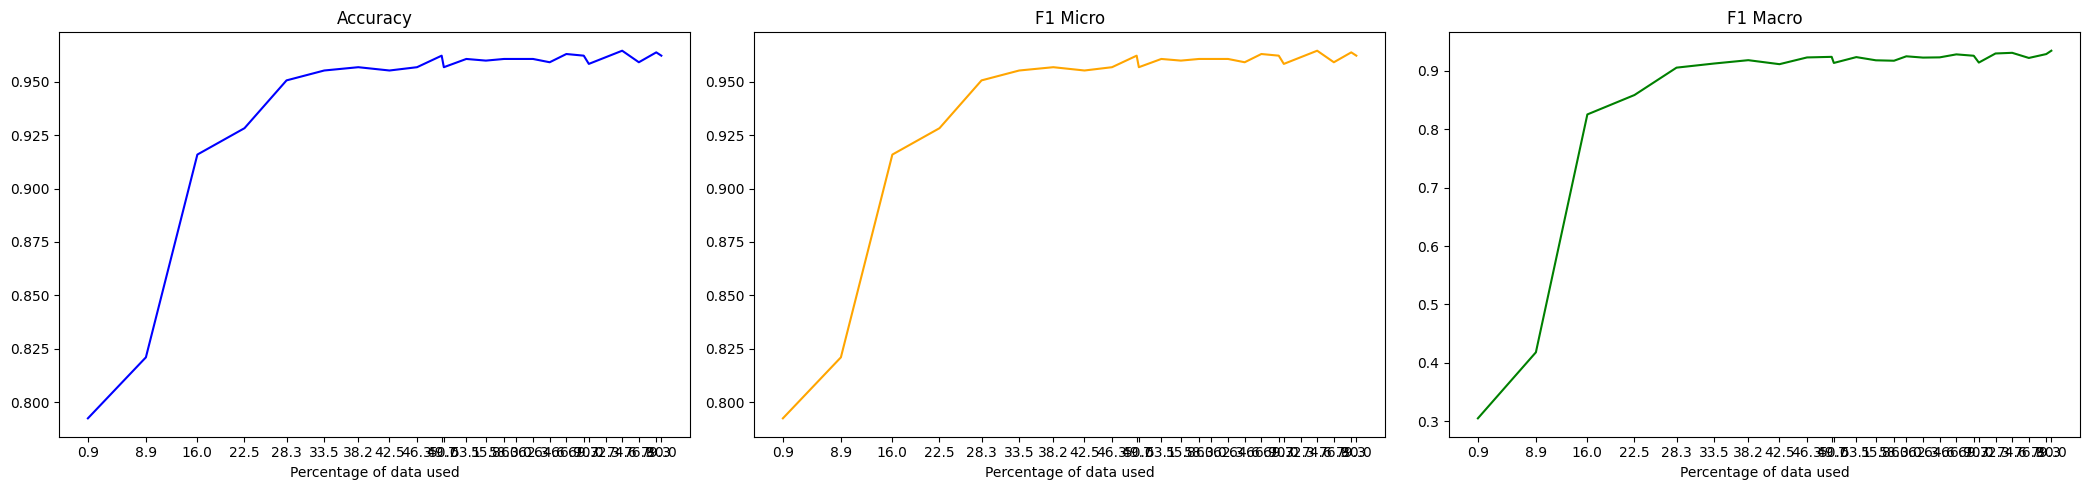

In [22]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6328, Accuracy: 0.7493, F1 Micro: 0.85, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4951, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4625, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4453, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4135, Accuracy: 0.7999, F1 Micro: 0.8872, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3939, Accuracy: 0.8177, F1 Micro: 0.8959, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3601, Accuracy: 0.846, F1 Micro: 0.91, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3088, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 2/10, Train Loss: 0.5679, Accuracy: 0.7374, F1 Micro: 0.7374, F1 Macro: 0.4244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5035, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 4/10, Train Loss: 0.4771, Accuracy: 0.7318, F1 Micro: 0.7318, F1 Macro: 0.5318
Epoch 5/10, Train Loss: 0.4109, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.622
Epoch 6/10, Train Loss: 0.3137, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.267, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1947, Accuracy: 0.7821, F1 Micro: 0.7821, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.1264, Accuracy: 0.7765, F1 Micro: 0.7765, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0975, Accuracy: 0.7542, F1 Micro: 0.7542, F1 Macro: 0.7018

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6122, Accuracy: 0.7924, F1 Micro: 0.8834, F1 Macro: 0.8817
Epoch 2/10, Train Loss: 0.5142, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4935, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4374, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4339, Accuracy: 0.8266, F1 Micro: 0.9005, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3763, Accuracy: 0.8631, F1 Micro: 0.9193, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3262, Accuracy: 0.9018, F1 Micro: 0.9399, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2714, Accuracy: 0.9182, F1 Micro: 0.9496, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.238, Accuracy: 0.9263, F1 Micro: 0.9544, F1 Macro: 0.952
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.6835, F1 Micro: 0.6835, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.54, Accuracy: 0.6835, F1 Micro: 0.6835, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4291, Accuracy: 0.7046, F1 Micro: 0.7046, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3679, Accuracy: 0.8397, F1 Micro: 0.8397, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2355, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8601
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.8734, F1 Micro: 0.8734, F1 Macro: 0.8585
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8461
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.8734, F1 Micro: 0.8734, F1 Macro: 0.8557
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8461
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.8523, F1 Micro: 0.8523, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5956, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.491, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4833, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4403, Accuracy: 0.8192, F1 Micro: 0.8971, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3853, Accuracy: 0.8795, F1 Micro: 0.9279, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3182, Accuracy: 0.9115, F1 Micro: 0.9451, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2557, Accuracy: 0.9286, F1 Micro: 0.9557, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2174, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6522, Accuracy: 0.6694, F1 Micro: 0.6694, F1 Macro: 0.401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5648, Accuracy: 0.6694, F1 Micro: 0.6694, F1 Macro: 0.401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8802, F1 Micro: 0.8802, F1 Macro: 0.8659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.244, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8762
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8966
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8906
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.89
Epoch 10/10, Train Loss: 0.0704, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5768, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4871, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4599, Accuracy: 0.8103, F1 Micro: 0.8927, F1 Macro: 0.8913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.384, Accuracy: 0.8921, F1 Micro: 0.935, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.316, Accuracy: 0.9152, F1 Micro: 0.9477, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2468, Accuracy: 0.9293, F1 Micro: 0.9558, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1876, Accuracy: 0.9368, F1 Micro: 0.9603, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1672, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9656
Epoch 9/10, Train Loss: 0.1414, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5798, Accuracy: 0.6858, F1 Micro: 0.6858, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4985, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3055, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9105
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8943
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9092
Epoch 8/10, Train Loss: 0.1217, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8898
Epoch 9/10, Train Loss: 0.1265, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9092
Epoch 10/10, Train Loss: 0.0886, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5554, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4647, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4283, Accuracy: 0.8609, F1 Micro: 0.9185, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3162, Accuracy: 0.9204, F1 Micro: 0.9508, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2542, Accuracy: 0.9368, F1 Micro: 0.9606, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1918, Accuracy: 0.9435, F1 Micro: 0.9646, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1598, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.123, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9687
Epoch 9/10, Train Loss: 0.1017, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6017, Accuracy: 0.6798, F1 Micro: 0.6798, F1 Macro: 0.4047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4464, Accuracy: 0.8775, F1 Micro: 0.8775, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.307, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334
Epoch 5/10, Train Loss: 0.203, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.924
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9119
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.911
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9188
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9245
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8959

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5559, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4629, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3982, Accuracy: 0.8876, F1 Micro: 0.9324, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3117, Accuracy: 0.936, F1 Micro: 0.9603, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2266, Accuracy: 0.9397, F1 Micro: 0.9627, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1823, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9695
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Epoch 8/10, Train Loss: 0.108, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0955, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5774, Accuracy: 0.6943, F1 Micro: 0.6943, F1 Macro: 0.4325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3694, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9271
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.919
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.923
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9185
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9104
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.8868, F1 Micro: 0.8868, F1 Macro: 0.8657

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5526, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4685, Accuracy: 0.808, F1 Micro: 0.8916, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.379, Accuracy: 0.9033, F1 Micro: 0.9412, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2822, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2096, Accuracy: 0.9479, F1 Micro: 0.9674, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1687, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9509, F1 Micro: 0.9691, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5672, Accuracy: 0.6829, F1 Micro: 0.6829, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3856, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9187
Epoch 4/10, Train Loss: 0.1221, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9229
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9064
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.9106
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0507, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.544, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4679, Accuracy: 0.8244, F1 Micro: 0.8998, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3705, Accuracy: 0.9196, F1 Micro: 0.9502, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2681, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2013, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6023, Accuracy: 0.6639, F1 Micro: 0.6639, F1 Macro: 0.399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4177, Accuracy: 0.9303, F1 Micro: 0.9303, F1 Macro: 0.9239
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 6/10, Train Loss: 0.0537, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9467, F1 Micro: 0.9467, F1 Macro: 0.9405
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9152
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9261
Epoch 10/10, Train Loss: 0.0613, Accuracy: 0.9426, F1 Micro: 0.9426, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4553, Accuracy: 0.8229, F1 Micro: 0.8991, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3523, Accuracy: 0.9234, F1 Micro: 0.9525, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2642, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1986, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1515, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5606, Accuracy: 0.8319, F1 Micro: 0.8319, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1329, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0922, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9264
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.9042
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9085
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9228
Epoch 10/10, Train Loss: 0.0399, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5322, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4397, Accuracy: 0.8482, F1 Micro: 0.9118, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3439, Accuracy: 0.9323, F1 Micro: 0.9579, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2345, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1815, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1408, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0769, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5784, Accuracy: 0.8192, F1 Micro: 0.8192, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3199, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9354
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9239
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9199
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9204
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.9423, F1 Micro: 0.9423, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5365, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4482, Accuracy: 0.8638, F1 Micro: 0.92, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.324, Accuracy: 0.9293, F1 Micro: 0.9555, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1764, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5696, Accuracy: 0.6721, F1 Micro: 0.6721, F1 Macro: 0.4245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3327, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1613, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9333
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8808
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9297
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9297
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9294
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9206
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.929

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5363, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4261, Accuracy: 0.8839, F1 Micro: 0.931, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3121, Accuracy: 0.9382, F1 Micro: 0.9615, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2269, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1691, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5388, Accuracy: 0.7352, F1 Micro: 0.7352, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9441
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9438
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9474
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4264, Accuracy: 0.9025, F1 Micro: 0.9407, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2985, Accuracy: 0.9405, F1 Micro: 0.9633, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.22, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.979
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5429, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.943
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.919
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9274
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9478
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9436
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9312
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9067

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4176, Accuracy: 0.9033, F1 Micro: 0.9417, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2965, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.8783, F1 Micro: 0.8783, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9321
Epoch 5/10, Train Loss: 0.1021, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9195
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9244
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9116
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9204

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4304, Accuracy: 0.8973, F1 Micro: 0.9371, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2982, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.965, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5747, Accuracy: 0.7569, F1 Micro: 0.7569, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9522
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.944
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9399
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9438
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9248
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9256
Epoch 10/10, Train Loss: 0.058, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9143

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.408, Accuracy: 0.9144, F1 Micro: 0.947, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2681, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9787
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.8845, F1 Micro: 0.8845, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9342
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9602, F1 Micro: 0.9602, F1 Macro: 0.9558
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9374
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.93
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9242
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0.9363, F1 Micro: 0.9363, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4036, Accuracy: 0.9167, F1 Micro: 0.9481, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2659, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5581, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2493, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9452
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9544, F1 Micro: 0.9544, F1 Macro: 0.9491
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9291
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9177
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9392, F1 Micro: 0.9392, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5226, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4025, Accuracy: 0.9122, F1 Micro: 0.9448, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2609, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0561, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5369, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.8265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Epoch 4/10, Train Loss: 0.1267, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9437
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9392
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Epoch 10/10, Train Loss: 0.0689, Accuracy: 0.9455, F1 Micro: 0.9455, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.399, Accuracy: 0.9129, F1 Micro: 0.9462, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9703
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4949, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.191, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9489
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9248
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9386
Epoch 9/10, Train Loss: 0.0954, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9389
Epoch 10/10, Train Loss: 0.0741, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.8095, F1 Micro: 0.8923, F1 Macro: 0.8913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3764, Accuracy: 0.9226, F1 Micro: 0.9515, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9197
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9337
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9157
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9326
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0624, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5211, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3741, Accuracy: 0.9211, F1 Micro: 0.9507, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2416, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9754, F1 Micro: 0.9846, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9287
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9441
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9362
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9421
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9048
Epoch 10/10, Train Loss: 0.0601, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9199

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5158, Accuracy: 0.8013, F1 Micro: 0.8881, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3805, Accuracy: 0.9286, F1 Micro: 0.9554, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9665, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.509, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.947
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.935
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9185
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5126, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.37, Accuracy: 0.9323, F1 Micro: 0.9578, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.23, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5055, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1545, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9384
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9346
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 10/10, Train Loss: 0.0581, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924

Sentiment analysis accuracy:

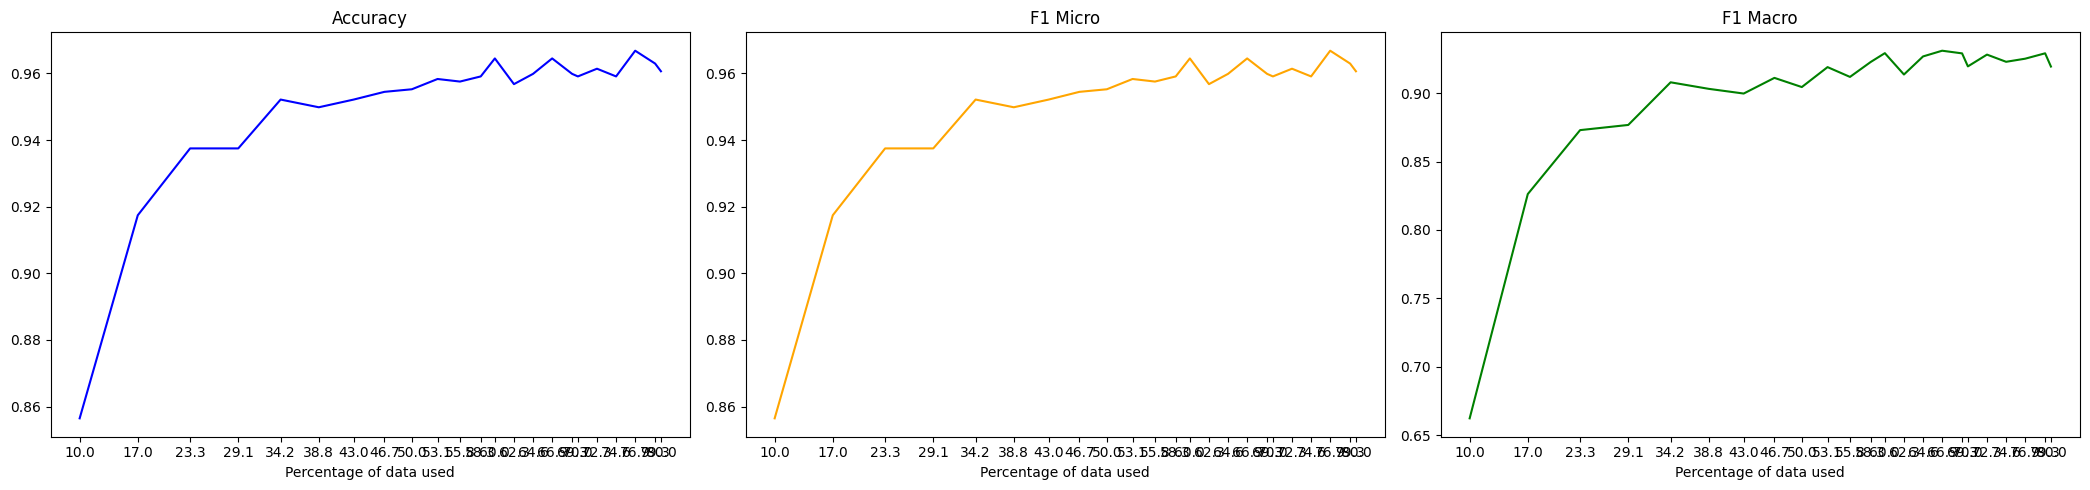

In [23]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)